In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from src.utils import *

torch.manual_seed(20)

In [2]:
from sklearn.model_selection import train_test_split
# import the data
train_x_orig, train_y, val_x_orig, val_y, classes = load_data('./data/train_catvnoncat.h5','./data/test_catvnoncat.h5')
train_y = train_y.reshape(209)
val_y = val_y.reshape(50)
train_x_orig, test_x_orig, train_y, test_y = train_test_split(train_x_orig, train_y, train_size=0.9, random_state=42)

# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_val = val_x_orig.shape[0]
m_test = test_x_orig.shape[0]


print ("Number of training examples: " + str(m_train))
print ("Number of validation examples: " + str(m_val))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 188
Number of validation examples: 50
Number of testing examples: 21
Each image is of size: (64, 64, 3)
train_x_orig shape: (188, 64, 64, 3)
train_y shape: (188,)
test_x_orig shape: (21, 64, 64, 3)
test_y shape: (21,)


In [3]:
# load the data into pytorch dataset object
class Data(Dataset):

    def __init__(self,x,y,transform):
        self.transform = transform
        self.x = x
        self.y = y
        self.len = y.shape[0]

    #Getter
    def __getitem__(self,index):
        img = self.x[index]
        x = self.transform(img)
        return x, self.y[index]
    
    #Getlength
    def __len__(self):
        return self.len
    
#plot example
def plot_img(dataset,i):
    x_ = dataset[i][0]
    y_ = dataset[i][1]
    print('y=',y_)
    to_pil = T.ToPILImage()
    img = to_pil(x_)
    img.show()

In [4]:
#define transformations for train and test set
transform_train = T.Compose([
    T.ToPILImage(),
    T.Resize([64,64]),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),  
    T.RandomResizedCrop(64),
    T.RandomRotation(45,expand=False),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])

transform_test =  T.Compose([
    T.ToPILImage(),
    T.Resize([64,64]),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])

In [5]:
#get test_data set
test_data = Data(test_x_orig,test_y,transform=transform_test)
val_data = Data(val_x_orig,val_y,transform=transform_test)

#get train_data set with random augmentation,this will triple the size the training data
train_data1 = Data(train_x_orig,train_y,transform=transform_train)
train_data2 = Data(train_x_orig,train_y,transform=transform_train)
train_data3 = Data(train_x_orig,train_y,transform=transform_train)
train_data4 = Data(train_x_orig,train_y,transform=transform_train)

train_data = ConcatDataset([train_data1, train_data2, train_data3, train_data4])

print('length of new train-data set after augmentation is:',len(train_data))
print('length of val dataset:',len(val_data))
print('length of test dataset:',len(test_data))

length of new train-data set after augmentation is: 752
length of val dataset: 50
length of test dataset: 21


y= 0


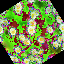

y= 0


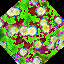

y= 0


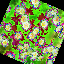

y= 0


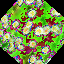

In [6]:
#plot example
plot_img(train_data1,110)
plot_img(train_data2,110)
plot_img(train_data3,110)
plot_img(train_data4,110)

A helper function that calculates the matrix dimension for all conv layers

In [7]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

### Train a CNN with 2 conv layers and 1 fully connected layer

In [8]:
# Dimensions for different layers
conv_kernel_size = 3
conv_pad = 1
maxpool_kernel_size = 2

shape=(64,64)
for i in range(4):
    shape = conv_output_shape(shape,kernel_size=conv_kernel_size,pad=conv_pad)
    conv_kernel_size+=2
    conv_pad+=1
    print(shape)
    shape = conv_output_shape(shape,kernel_size=maxpool_kernel_size,stride=maxpool_kernel_size)
    print(shape)

(64, 64)
(32, 32)
(32, 32)
(16, 16)
(16, 16)
(8, 8)
(8, 8)
(4, 4)


In [9]:
# Create Net model class, activation=relu, softmax for the last layer

class CNN(nn.Module):
    
    # Contructor
    def __init__(self, cnn_layers, ff_layers):
        super(CNN, self).__init__()
        #maxpool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        #conv layer
        self.cnn = nn.ModuleList()
        kernel_size = 3
        padding = 1
        for in_channels, out_channels in zip(cnn_layers,cnn_layers[1:]):
            self.cnn.append(nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,padding=padding))
            kernel_size+=2
            padding+=1
        
        #batch norm layer
        self.cnn_bn = nn.ModuleList()
        for out_channels in cnn_layers[1:]:
            self.cnn_bn.append(nn.BatchNorm2d(out_channels))

        #Feedforward
        self.ff = nn.ModuleList()
        self.ff_bn = nn.ModuleList()
        ff_layers.insert(0,cnn_layers[-1]*4*4)
        for input_size, output_size in zip(ff_layers, ff_layers[1:]):
            self.ff.append(nn.Linear(input_size, output_size))
            self.ff_bn.append(nn.BatchNorm1d(output_size))
    
    # Prediction
    def forward(self, x):
        #cnn layers
        for convolution, bn in zip(self.cnn,self.cnn_bn):
            x = convolution(x)
            x = bn(x)
            x = torch.relu(x)
            x = self.maxpool(x)       

        #Feedforward
        x = x.view(x.size(0), -1)
        L = len(self.ff)
        for (l, linear_transform, linear_bn) in zip(range(L), self.ff, self.ff_bn):
            if l < L - 1:
                x = F.relu(linear_transform(x))
                x = linear_bn(x)
            else:
                x = linear_transform(x)
                x = linear_bn(x)
        return x

In [10]:
# Create the model object using CNN class
cnn_layers = [3,64,64,128,128]
ff_layers = [20,7,5,2]
model = CNN(cnn_layers,ff_layers)

In [11]:
model.parameters

<bound method Module.parameters of CNN(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  )
  (cnn_bn): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ff): ModuleList(
    (0): Linear(in_features=2048, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in

In [12]:
#set loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# create test loader for BGD
train_loader = DataLoader(train_data,batch_size=20,shuffle=True)
val_loader = DataLoader(val_data,batch_size=len(val_data))
test_loader = DataLoader(test_data,batch_size=len(test_data))

In [13]:
# Define the function for training the model
from src.utils import EarlyStopping

def predict(model,data_loader):
    result = {}
    losses = []
    correct=0
    m = 0 #length of the dataset
    for x,y in data_loader:
        model.eval()
        y_ = model(x)
        #calculate loss
        losses.append(criterion(y_, y).data.item())
        #calculate accuracy
        _, label = torch.max(y_.data,1)
        correct += torch.sum(y==label).item()
        m+=len(y)
    accuracy = correct/m
    loss = sum(losses)/len(losses)
    result['accuracy'] = accuracy
    result['loss'] = loss

    return(result)

def train(model, criterion, train_loader, optimizer, epoch=1000):

    result = {
        'train_loss':[],
        'train_cost':[],
        'val_loss':[],
        'val_accuracy':[],
    }

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)

    for i in range(epoch):
        #################
        #Train the model#
        #################
        COST = 0#train cost
        losses = []
        for x, y in train_loader:
            model.train()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            COST+=loss.data.item()
            losses.append(loss.data.item())
        result['train_cost'].append(COST)
        LOSS = np.average(losses) #train loss
        result['train_loss'].append(LOSS)

        ##################################
        #print status for every 50 epochs#
        ##################################
        if i%50==0:
            print(f"training COST after {i} epochs is {COST}")

        ######################################
        #get validation result for each epoch#
        ######################################
        val_result = predict(model,val_loader)
        result['val_loss'].append(val_result['loss'])
        result['val_accuracy'].append(val_result['accuracy'])
        
        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_result['loss'], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, result

In [14]:
#train the model
model, train_result = train(model,criterion,train_loader,optimizer,epoch=2000)

training COST after 0 epochs is 25.682278275489807
Validation loss decreased (inf --> 0.801418).  Saving model ...
Validation loss decreased (0.801418 --> 0.799277).  Saving model ...
Validation loss decreased (0.799277 --> 0.606375).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.606375 --> 0.546702).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.546702 --> 0.482896).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.482896 --> 0.424649).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
Validation loss decreased (0.424649 --> 0.365804).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping co

Text(0, 0.5, 'loss')

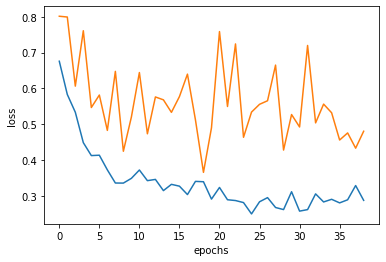

In [15]:
# plot the change in loss
plt.plot(train_result['train_loss'])
plt.plot(train_result['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

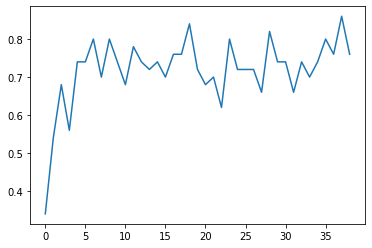

In [18]:
#plot test accuracy
plt.plot(train_result['val_accuracy'])

In [19]:
#run the model on the test set and calculate accuracy
predict(model,test_loader)

{'accuracy': 0.9047619047619048, 'loss': 0.2338848114013672}